In [4]:
#!pip install xgboost

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv(r'/content/Airbnb_data - airbnb_data.csv')

In [7]:
df.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [8]:
print(df.shape)

(74111, 29)


In [9]:
print(df.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

##Dropping Irrelevant columns:-

```
1. id :- Unique indentifier( It is only for refrence purpose).
2. name :- Listing title written by the host (text, inconsistent).
3. description:- Free text, requiring NLP to be useful
4. thumbnail_url :- image link, not being analyzed.
```



In [11]:
df.drop(['id','name','description','thumbnail_url'], axis = 1, inplace = True)

In [12]:
print('After dropping columns')
print(df.shape)

After dropping columns
(74111, 25)


In [13]:
df.isnull().sum()

,0
log_price,0
property_type,0
room_type,0
amenities,0
accommodates,0
bathrooms,200
bed_type,0
cancellation_policy,0
cleaning_fee,0
city,0


## Function Explanation:-
    1. df.isnull().sum(): - Counts the total number of missing values in each columns.
    2. Percentage Calculation: - Divides the number of missing values by the total rows to understand the severity.
    3. pd.concat() : - Combines the missing values and percentage into one clean tabe.
    4. Renaming columns :- Adds descriptive columns name(Missing values, % of Total Values).
    5. Filtering:- Removes columns that have no missing value, keeps only those having null values.
    6. Sorting & Rounding : - Makes the table easier to read by ordering from most to least missing values.

In [14]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        missing_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, missing_val_percent], axis = 1)
        mis_val_table = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table = mis_val_table[mis_val_table['Missing Values'] > 0]
        mis_val_table = mis_val_table.sort_values('% of Total Values', ascending = False).round(2)
        return mis_val_table

In [15]:
missing_values_table(df)

,Missing Values,% of Total Values
host_response_rate,18299,24.69
review_scores_rating,16722,22.56
first_review,15864,21.41
last_review,15827,21.36
neighbourhood,6872,9.27
zipcode,968,1.31
bathrooms,200,0.27
host_has_profile_pic,188,0.25
host_identity_verified,188,0.25
host_since,188,0.25


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  first_review            58247 non-null  object 
 11  host_has_profile_pic    73923 non-null  object 
 12  host_identity_verified  73923 non-null  object 
 13  host_response_rate      55812 non-null  object 
 14  host_since              73923 non-null

In [17]:
df.host_response_rate.unique()

array([nan, '100%', '71%', '68%', '67%', '83%', '50%', '90%', '86%',
       '92%', '82%', '80%', '89%', '93%', '99%', '0%', '88%', '96%',
       '70%', '94%', '91%', '25%', '95%', '98%', '62%', '29%', '33%',
       '81%', '63%', '38%', '60%', '79%', '78%', '75%', '65%', '97%',
       '87%', '40%', '54%', '53%', '58%', '76%', '30%', '64%', '17%',
       '20%', '77%', '73%', '41%', '59%', '57%', '85%', '56%', '42%',
       '44%', '35%', '14%', '74%', '27%', '10%', '84%', '6%', '72%',
       '36%', '55%', '43%', '13%', '39%', '46%', '26%', '61%', '52%',
       '23%', '22%', '69%', '66%', '15%', '11%', '31%', '21%', '47%'],
      dtype=object)

In [18]:
df.host_response_rate = df.host_response_rate.str.replace('%', '', regex = True)

In [19]:
df.host_response_rate = df.host_response_rate.astype(float)

In [20]:
def detect_outliers(df):
    outlier_summary = {}
    numeric_columns = df.select_dtypes(include = [np.number]).columns

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_percentage = round((len(outliers) / len(df)) * 100, 2)

        outlier_count = len(outliers)

        outlier_summary[column] = {
            "Total Values": len(df),
            "Outliers": len(outliers),
            "Outlier %": outliers_percentage
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by="Outlier %", ascending=False)

In [21]:
detect_outliers(df)

,Total Values,Outliers,Outlier %
bedrooms,74111.0,24236.0,32.70
bathrooms,74111.0,15812.0,21.34
host_response_rate,74111.0,12558.0,16.94
number_of_reviews,74111.0,8203.0,11.07
beds,74111.0,5686.0,7.67
accommodates,74111.0,3604.0,4.86
review_scores_rating,74111.0,1719.0,2.32
log_price,74111.0,1532.0,2.07
longitude,74111.0,0.0,0.00
latitude,74111.0,0.0,0.00


    High outliers:- Bedrooms and bathrooms have unusually high number of outliers.

    Moderate outliers: - Host_reponse_rate, review_scores_rating and log_price have 7 - 17% outliers. These may represent extreme but possible cases( Hosts with thousands of reviews or beds in shared spaces).

    Low outliers:- Accomadates, review_score_rating, and log_price have 2 - 5% outliers.

    No Outliers: - latitude and longitude have no statistical outliers(as expected, since they are bounded by geography).

    1. Capping extreme values for numerical columns like bedrooms and bathrooms to avoid unrealistic entries.
    2. Handling outliers in features such as number_of_reviews, beds, and host_response_rate using the 99th percentile, which limits only the top 1% extreme values without affecting most of the data.
    3. Applying lower and upper limits on columns like log_price, accommodates, and review_scores_rating using the interquartile range (IQR) to reduce the impact of extreme low and high values.

In [22]:
def handle_outliers(df):
    df['bedrooms'] = np.where(df['bedrooms'] > 10, 10, df['bedrooms'])
    df['bathrooms'] = np.where(df['bathrooms'] > 8, 8, df['bathrooms'])

    for col in ['number_of_reviews', 'beds', 'host_response_rate']:
        upper_limit = df[col].quantile(0.99)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

    for col in ['log_price', 'accommodates', 'review_scores_rating']:
        lower_limit = df[col].quantile(0.01)
        upper_limit = df[col].quantile(0.99)
        df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

    return df


Used the 99th percentile to handle extreme highs, but leave the lows if they are valid. In contrast, in the second loop, you handle both upper and lower limits for columns where extreme low values are also problematic (like log_price or review_scores_rating).

In [23]:
df = handle_outliers(df)

outlier_report_after = detect_outliers(df)
print(outlier_report_after)


                      Total Values  Outliers  Outlier %
bedrooms                   74111.0   24236.0      32.70
bathrooms                  74111.0   15812.0      21.34
host_response_rate         74111.0   12558.0      16.94
number_of_reviews          74111.0    8203.0      11.07
beds                       74111.0    5686.0       7.67
accommodates               74111.0    3604.0       4.86
review_scores_rating       74111.0    1719.0       2.32
log_price                  74111.0    1372.0       1.85
longitude                  74111.0       0.0       0.00
latitude                   74111.0       0.0       0.00


In [24]:
df

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3.0,1.0,Real Bed,strict,True,NYC,...,f,18-07-2016,40.696524,-73.991617,Brooklyn Heights,2.0,100.0,11201,1.0,1.0
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7.0,1.0,Real Bed,strict,True,NYC,...,t,23-09-2017,40.766115,-73.989040,Hell's Kitchen,6.0,93.0,10019,3.0,3.0
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5.0,1.0,Real Bed,moderate,True,NYC,...,t,14-09-2017,40.808110,-73.943756,Harlem,10.0,92.0,10027,1.0,3.0
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4.0,1.0,Real Bed,flexible,True,SF,...,f,NaN,37.772004,-122.431619,Lower Haight,0.0,NaN,94117,2.0,2.0
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2.0,1.0,Real Bed,moderate,True,DC,...,t,22-01-2017,38.925627,-77.034596,Columbia Heights,4.0,60.0,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4.605170,Apartment,Private room,{},1.0,1.0,Real Bed,flexible,False,NYC,...,f,NaN,40.709025,-73.939405,Williamsburg,0.0,NaN,11206,1.0,1.0
74107,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4.0,2.0,Real Bed,moderate,True,LA,...,f,15-04-2017,33.871549,-118.396053,Hermosa Beach,16.0,93.0,90254,2.0,4.0
74108,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5.0,1.0,Real Bed,moderate,True,NYC,...,t,10-09-2017,40.706749,-73.942377,Williamsburg,43.0,94.0,11206,2.0,2.0
74109,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2.0,1.0,Real Bed,strict,True,NYC,...,t,NaN,40.738535,-74.000157,West Village,0.0,NaN,10011,0.0,2.0


In [25]:
print("Bedrooms → Min:", df['bedrooms'].min(), "Max:", df['bedrooms'].max())
print("Bathrooms → Min:", df['bathrooms'].min(), "Max:", df['bathrooms'].max())

Bedrooms → Min: 0.0 Max: 10.0
Bathrooms → Min: 0.0 Max: 8.0


####The distributions of bedrooms and bathrooms were visualized after cleaning using histograms. Count labels were added on each bar to clearly show the frequency of each value, helping identify the most common values and extreme cases

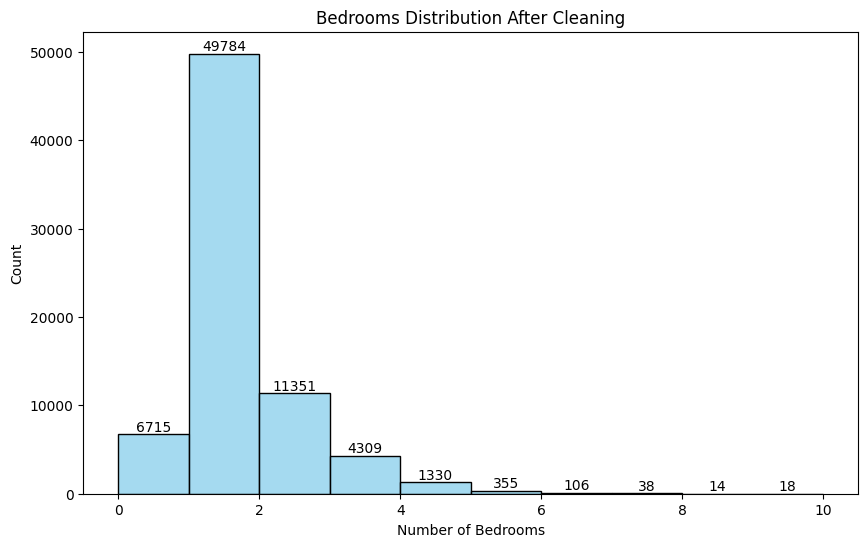

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bed_plot = sns.histplot(df['bedrooms'].dropna(), bins=10, stat='count', color='skyblue', kde=False)
plt.title("Bedrooms Distribution After Cleaning")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")

for p in bed_plot.patches:
    bed_plot.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()),
                      ha='center', va='bottom', fontsize=10)

plt.show()

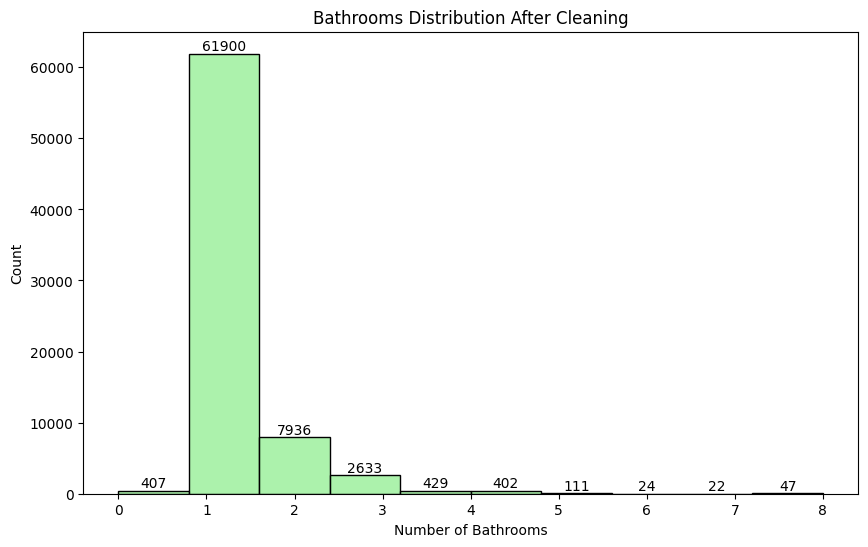

In [27]:

plt.figure(figsize=(10,6))
bath_plot = sns.histplot(df['bathrooms'].dropna(), bins=10, stat='count', color='lightgreen', kde=False)
plt.title("Bathrooms Distribution After Cleaning")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

for p in bath_plot.patches:
    bath_plot.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()),
                       ha='center', va='bottom', fontsize=10)

plt.show()


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  float64
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  first_review            58247 non-null  object 
 11  host_has_profile_pic    73923 non-null  object 
 12  host_identity_verified  73923 non-null  object 
 13  host_response_rate      55812 non-null  float64
 14  host_since              73923 non-null

###I impute missing values in the dataset to ensure that our analysis and modeling are not affected by null entries. The strategy depends on the type of data in each column:-
    1. Numerical Columns:-
        (a). For columns with numerical values(like bedrooms, bathrooms, review_scores_rating, host_response_rate), missing values are replaced with the median.
        (b). The median is used because it is robust to outliers and represents the central tendency of the data more accurately than the mean, especially in skewed distributions.
    
    2. Categorical columns:-
        (a). For columns with categorical values (like neighbourhood, zipcode, host_identity_verified), missing values are replaced with the 'Unknown'.
        (b). This explicitly marks missing entries, prevents bias, and allows models to treat them as a separate category.

In [29]:
def impute_missing_values(df):

    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
        else:
            mode_val = df[col].mode()[0]
            df[col].fillna('Unknown', inplace=True)
    return df


In [30]:
df = impute_missing_values(df)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  float64
 5   bathrooms               74111 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  first_review            74111 non-null  object 
 11  host_has_profile_pic    74111 non-null  object 
 12  host_identity_verified  74111 non-null  object 
 13  host_response_rate      74111 non-null  float64
 14  host_since              74111 non-null

##Data Analysis


---


####With the dataset fully cleaned and preprocessed, we now move to Data Analysis. This step is crucial to understand patterns, distributions, and relationships in the data. It helps to extract meaningful insights that can guide business decisions or predictive modeling.

####We will perform the analysis in three main stages:
    1. Univariate Analysis
    2. Bivariate Analysis
    3. Multivariate Analysis

##1. Univariate Analysis

####Why Univariate Analysis is Important:-




```
Provides basic understanding of each variable.

Helps to detect errors, skewness, and outliers.

Guides further analysis, feature engineering, and modeling decisions.

Gives insights into customer preferences (e.g., common room types, price ranges).
```



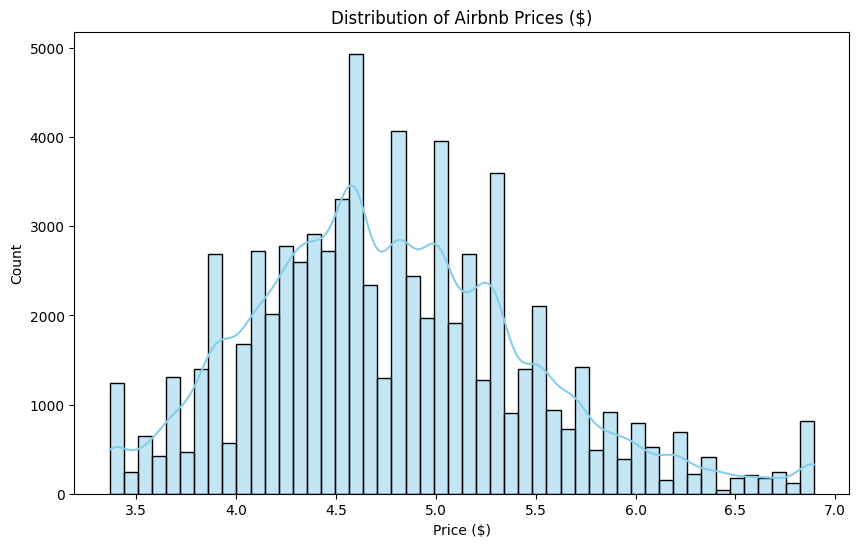

,log_price
count,74111.000000
mean,4.782618
std,0.703489
min,3.367296
25%,4.317488
50%,4.709530
75%,5.220356
max,6.894467


In [32]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_price'], bins=50, color='skyblue', kde=True)
plt.title("Distribution of Airbnb Prices ($)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

# Basic statistics
df['log_price'].describe()


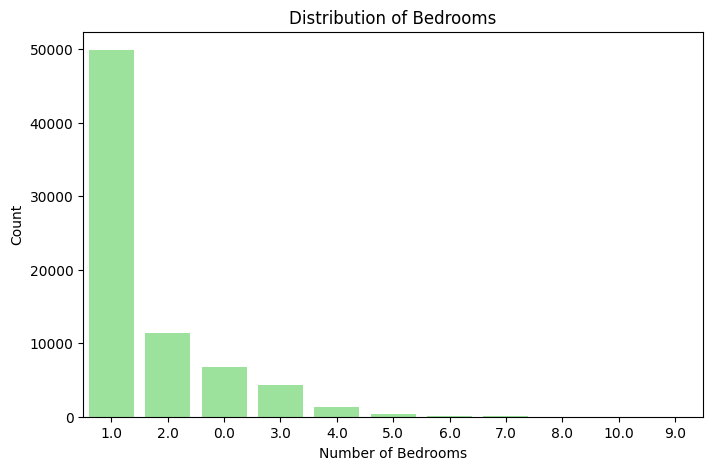

In [33]:
# Bedrooms
plt.figure(figsize=(8,5))
sns.countplot(x='bedrooms', data=df, color='lightgreen', order=df['bedrooms'].value_counts().index)
plt.title("Distribution of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")
plt.show()



In [34]:
df['bathrooms'] = df['bathrooms'].replace(0, 1)

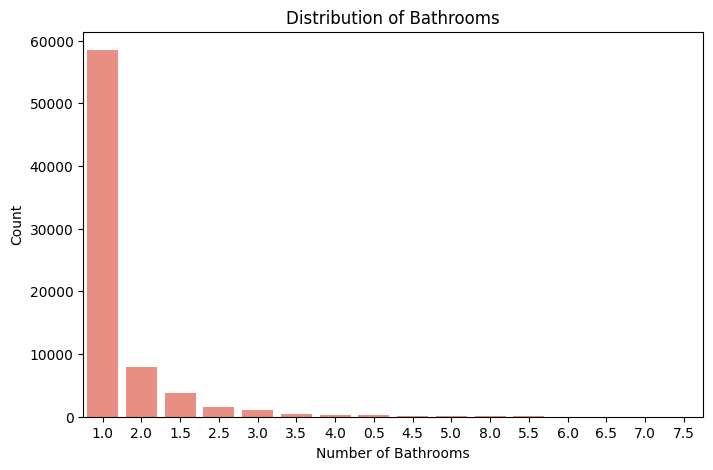

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(x='bathrooms', data=df, color='salmon', order=df['bathrooms'].value_counts().index)
plt.title("Distribution of Bathrooms")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")
plt.show()


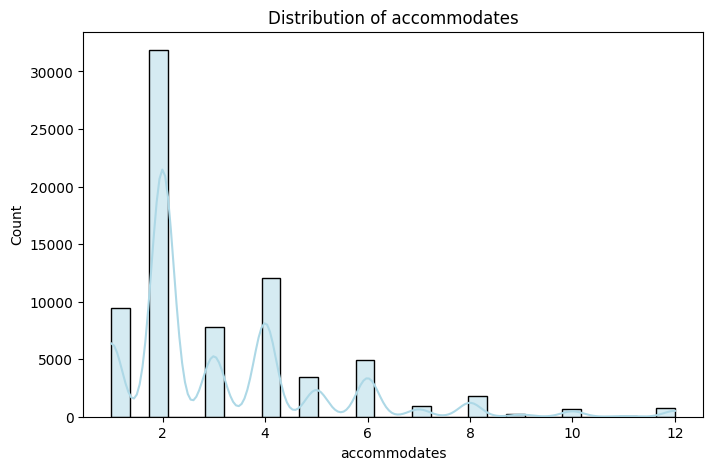

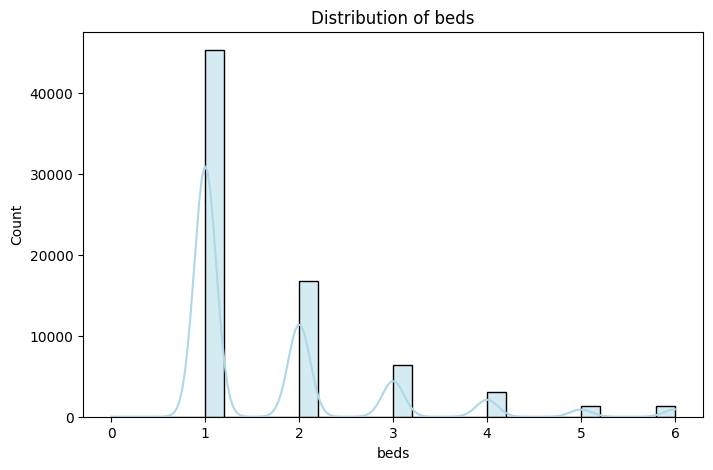

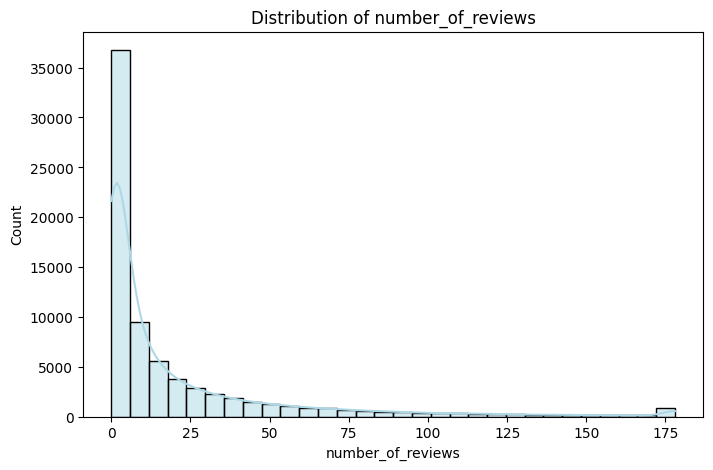

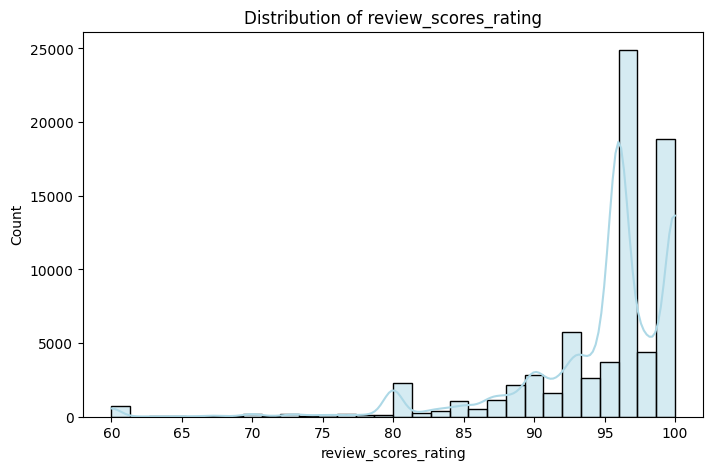

In [36]:
numerical_cols = ['accommodates', 'beds', 'number_of_reviews', 'review_scores_rating']
for col in numerical_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], bins=30, kde=True, color='lightblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

####Before training our Linear Regression model to predict price, it’s important to handle skewed features and the target variable. Skewed data can affect model performance and residuals.


```
1. Number_of_reviews column is right-skewed, with most listings having few reviews and a few having hundreds.
2. Applied log transformation (np.log1p) to reduce the influence of extreme values.
3. This makes the relationship between number of reviews and price more linear, which is ideal for Linear Regression.
```




In [37]:
df['log_reviews'] = np.log1p(df['number_of_reviews'])
df.drop('number_of_reviews', axis =1 , inplace = True)

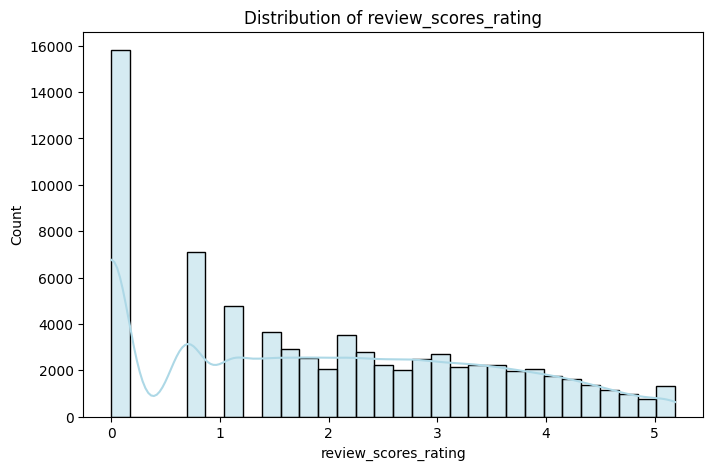

In [38]:
plt.figure(figsize=(8,5))
sns.histplot(df['log_reviews'], bins=30, kde=True, color='lightblue')
plt.title(f"Distribution of {col}")
plt.xlabel(col)
plt.ylabel("Count")
plt.show()


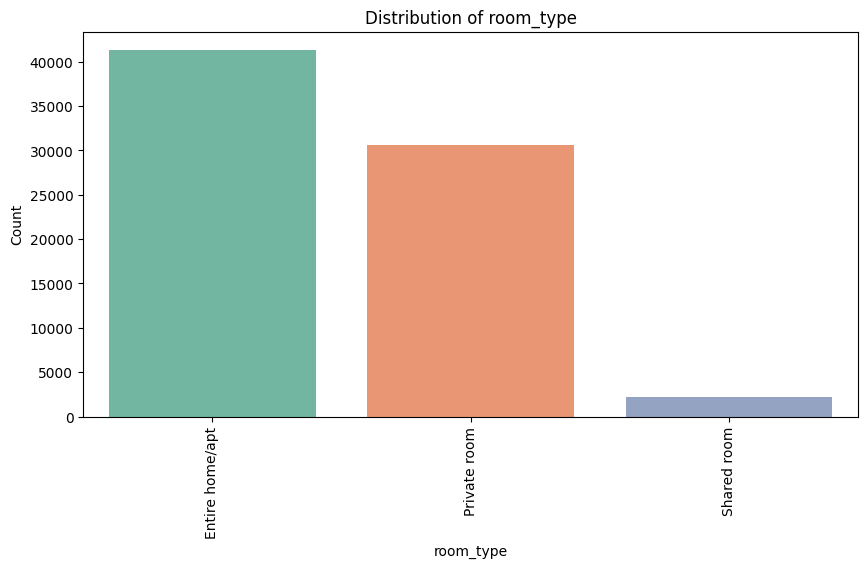

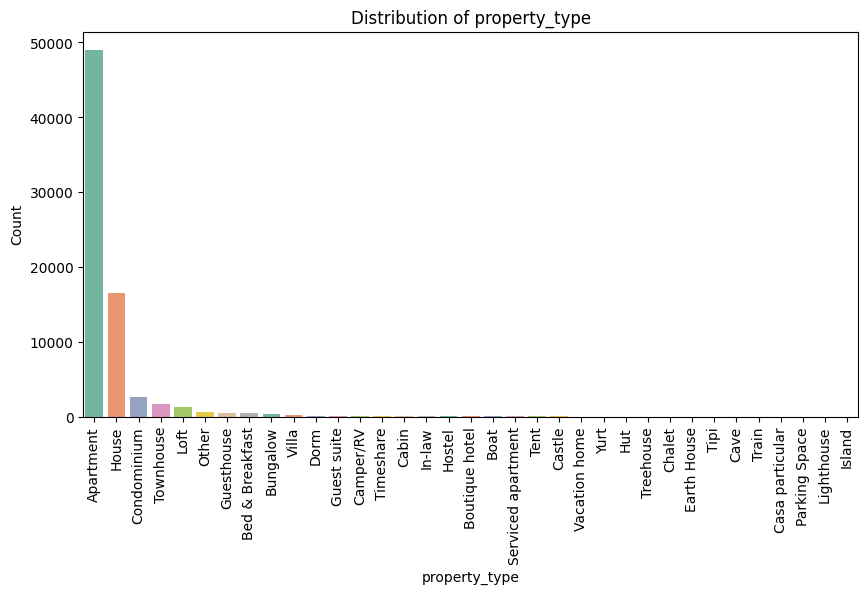

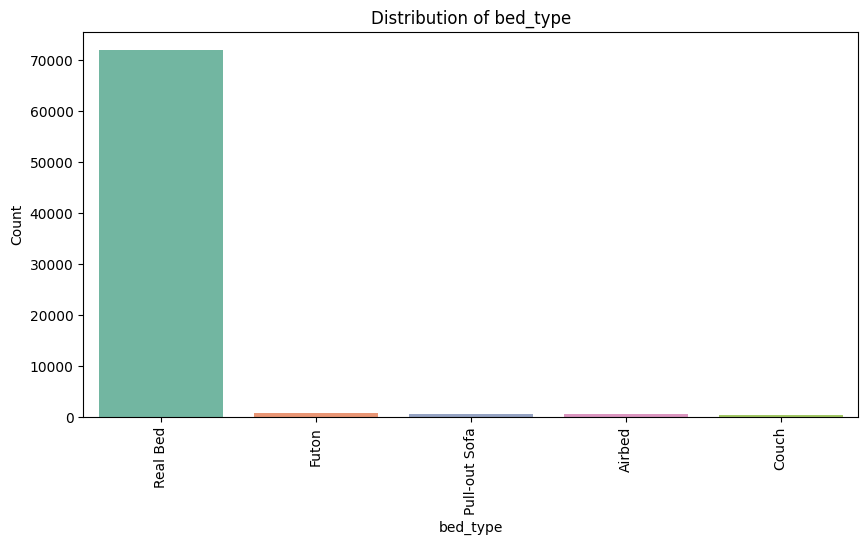

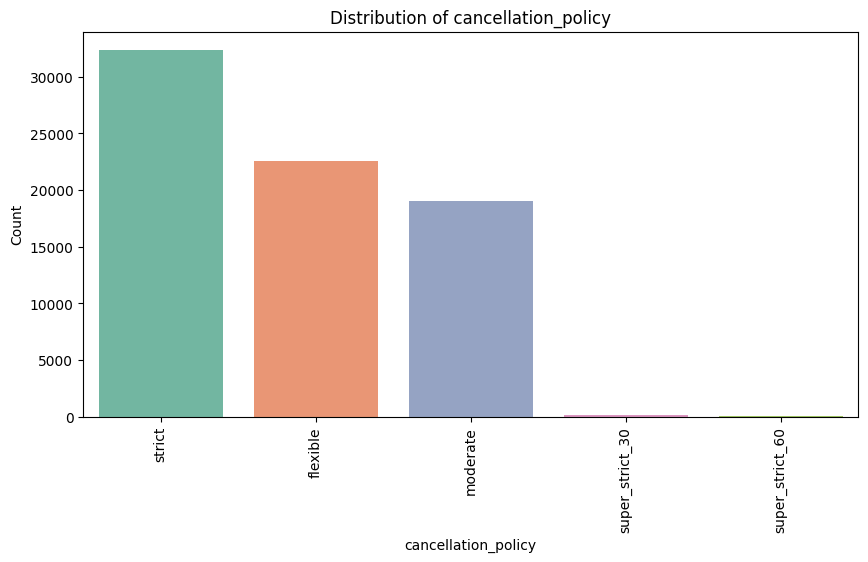

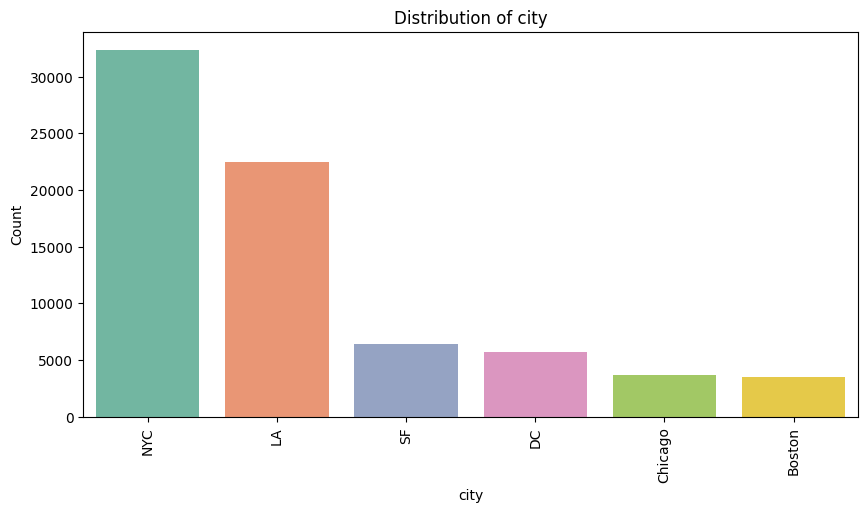

In [39]:
categorical_cols = ['room_type', 'property_type', 'bed_type', 'cancellation_policy', 'city']
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette='Set2')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()


##2. Bivariate Analysis

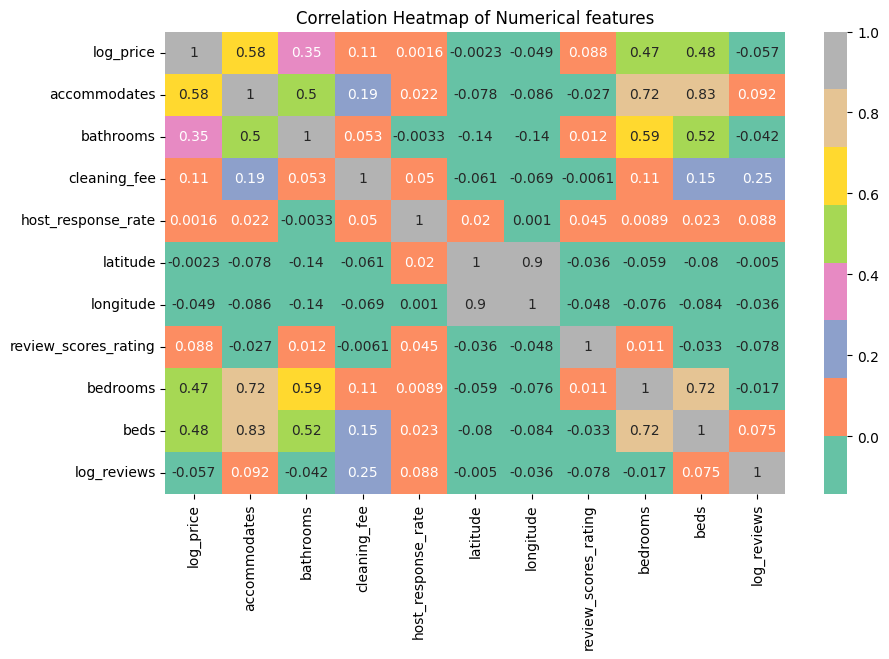

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only= True), annot = True, cmap = 'Set2')
plt.title("Correlation Heatmap of Numerical features")
plt.show()

####Correlation heatmap shows moderate positive correlation of accommodates, bedrooms, and bathrooms with log_price. The correlation between review_scores_rating and price is weak, meaning ratings don’t strongly drive price.



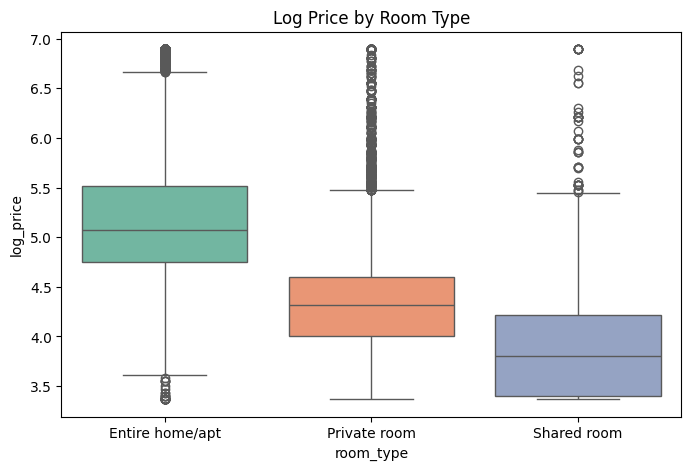

In [41]:
plt.figure(figsize=(8,5))
sns.boxplot(x='room_type', y='log_price', data=df, palette='Set2')
plt.title("Log Price by Room Type")
plt.show()


###Log Price by Room Type:-

```
1. Entire home/apt listings have the highest median log price and the widest spread, indicating that they are generally the most expensive but vary a lot depending on property size and amenities.
2. Private rooms fall in the mid-range, with a lower median compared to entire homes, but still showing a wide distribution due to location and property differences.
3. Shared rooms have the lowest prices overall, with very limited variation, confirming that they are the most budget-friendly option on Airbnb.
```



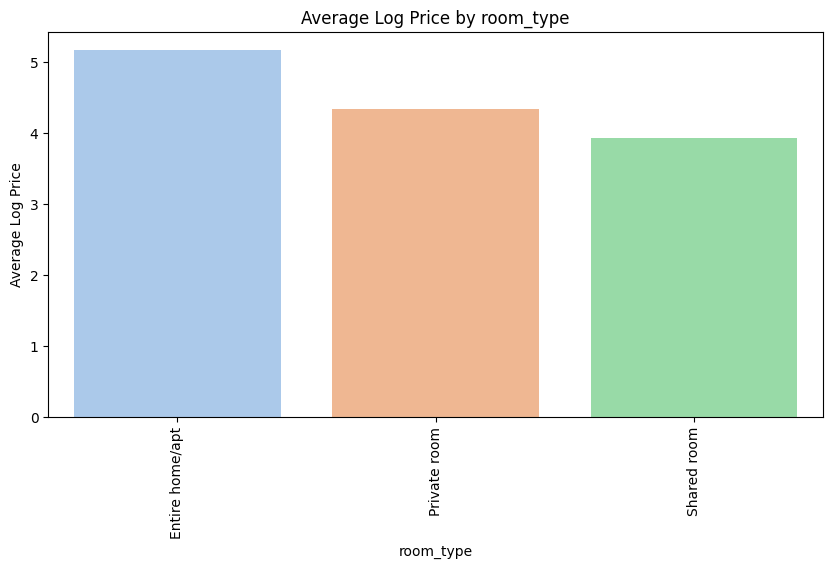

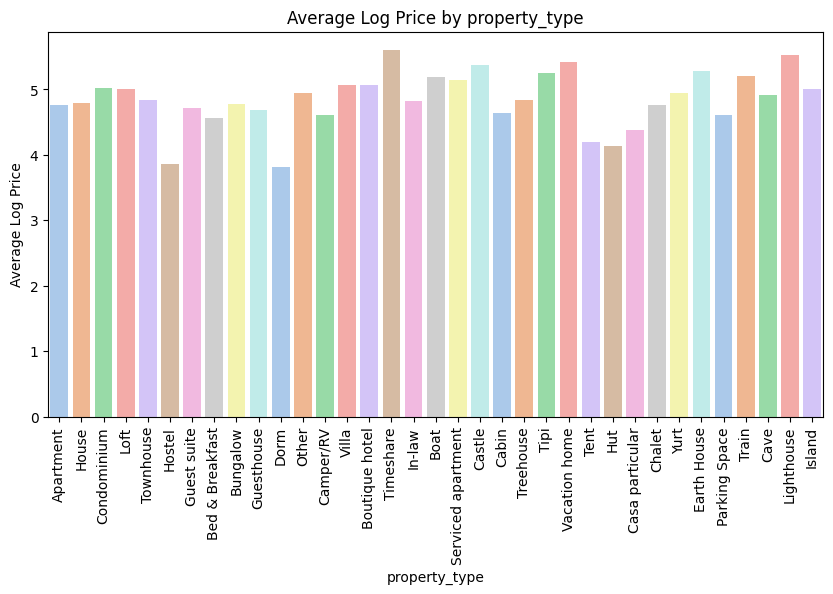

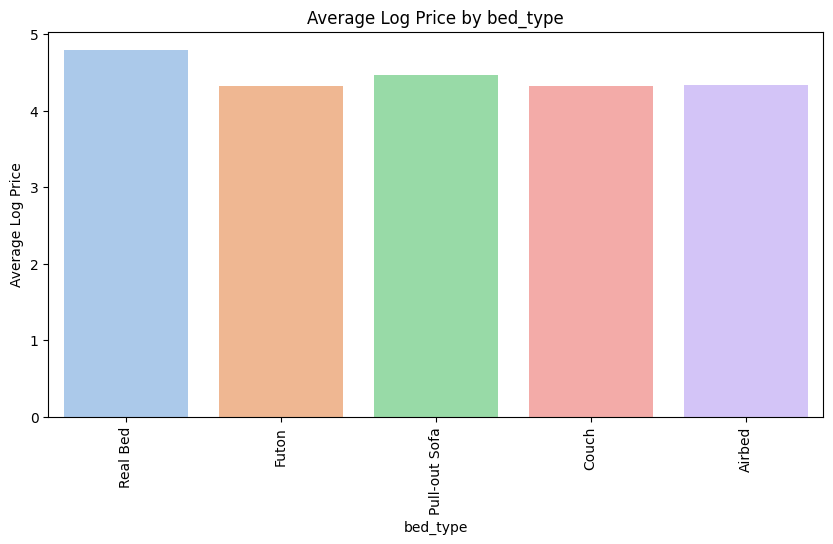

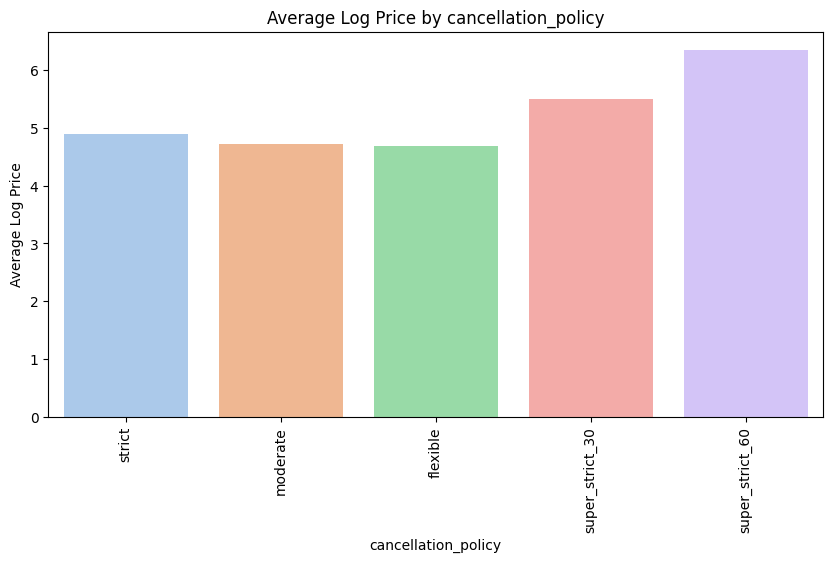

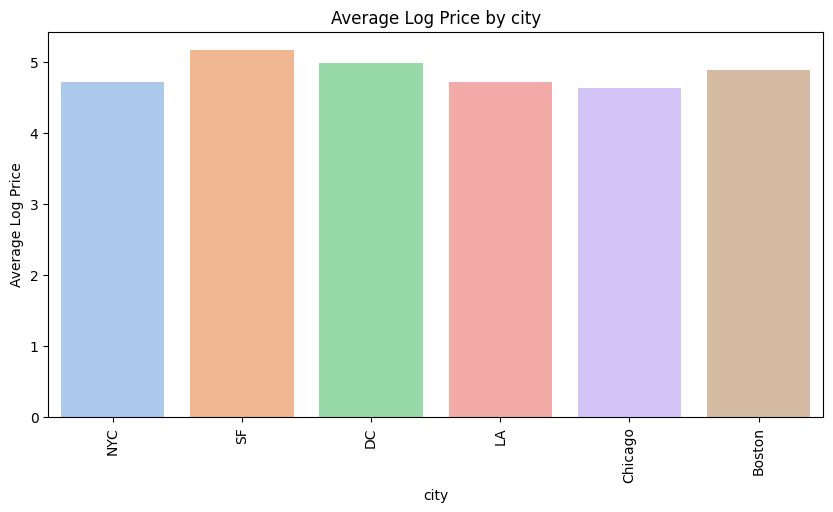

In [42]:
categorical_cols = ['room_type', 'property_type', 'bed_type', 'cancellation_policy', 'city']
for col in categorical_cols:
  plt.figure(figsize=(10,5))
  sns.barplot(x=col, y = 'log_price', data= df,  ci=None, palette='pastel')
  plt.title(f"Average Log Price by {col}")
  plt.xlabel(col)
  plt.ylabel("Average Log Price")
  plt.xticks(rotation=90)
  plt.show()


##Categorical Features V/S Log_Price By using Barplots:-

    1. Room Type:-
        (a). Entire home/apt listings have the highest log Price, makeing them the most expensive option.
        (b). Private rooms are priced moderatly, while shared rooms have the lowest prices.
    2. Property Type:-
        (a). Houses, lofts, and villas show higher log prices compared to apartments.
        (b). Smaller or budget-friendly property types such as hostels and Dorm are priced lower.
    3. Bed Type:-
        (a). Listing with real beds dominate the dataset and also tend to have higher log Price.
        (b). Other types (like futons, sofa beds, or pull-out couches) are linked to relatively lower prices.
    4. Cancellation Policy
        (a). Listing with a super_strict_60 cancellation policy tend to have higher average log prices compared to Moderate or Flexible policies.
    5. City:-
        (a). The log price across all cities lies in a narrow range between 4.5 and 5.
        (b). This indicates that while there are small differences, Airbnb prices are fairly consistent across different cities in the dataset.
---



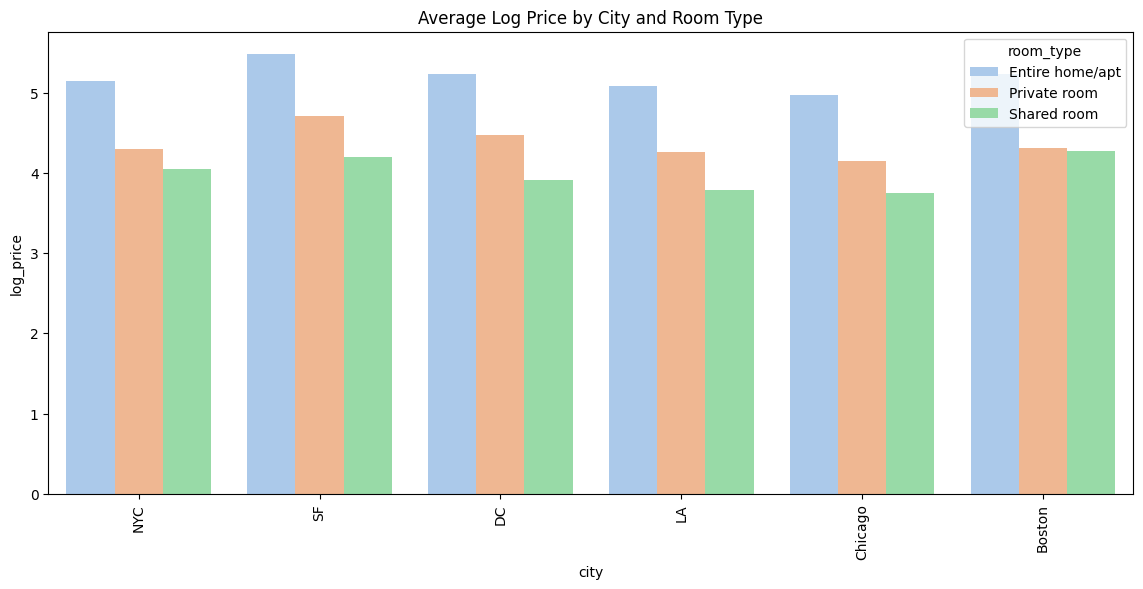

In [43]:
plt.figure(figsize=(14,6))
sns.barplot(x='city', y='log_price', hue='room_type', data=df, ci=None, palette='pastel')
plt.title("Average Log Price by City and Room Type")
plt.xticks(rotation=90)
plt.show()


##City and Room Type V/s Log Price:-

```
1. Across cities, Entire home/apt consistently has the highest average prices, while Shared rooms remain the cheapest option everywhere.
2. Although overall city averages are close (4–5), the difference between room types within the same city is significant, confirming that room type is a stronger driver of price than location alone.
```



In [44]:
df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')))

## Why we used Amenities_count?
####Ans:-  amenities column is a long text string with a list of items. instead of using the raw text, we extracted the number of amenities available in each listing. This matters because properties with more amenities(Wi-Fi, AC, Kitchen, etc) usually charge higher prices. By converting it into a count, we provide the model with a simple numerical feature that captures the effect of amenities on price.

In [45]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days
# Missing values were filled with the median so the model can still use this feature consistently.
df['days_since_last_review'] = df['days_since_last_review'].fillna(df['days_since_last_review'].median())


In [46]:
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_tenure'] = (pd.to_datetime('today') - df['host_since']).dt.days
# Missing values were replaced with the median to avoid losing records and to maintain consistency.
df['host_tenure'] = df['host_tenure'].fillna(df['host_tenure'].median())


## Date-Based Feature:-
    1. days_since_last_review:-
        (a). Number of days b/w today's date and the most recent review date for listing.
        (b). Caputures the recency of guest activity. Properties with very recent reviews may signal higher popularity and reliablity, while listing with older or no reviews may indecate lower engagement or trust.
    2. Host Tenure:-
        (a). Number of days b/w today's date and the date when the host first joined Airbnb.
        (b). Reflects the host's expreiance on the plateform. More expreienced hosts are likely to have better guest handling, which can influence pricing and booking likelihood.
  

In [47]:
df.drop(['amenities','first_review','last_review','host_since','zipcode'], axis=1, inplace=True)

In [48]:
cat_cols = ['property_type', 'room_type', 'bed_type',
            'cancellation_policy', 'city', 'neighbourhood']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Columns: 685 entries, log_price to neighbourhood_Wrigleyville
dtypes: bool(669), float64(12), int64(1), object(3)
memory usage: 56.3+ MB


In [50]:
df = df.drop(columns=['host_identity_verified', 'host_has_profile_pic'])


In [51]:
df.instant_bookable.unique()

array(['f', 't'], dtype=object)

In [52]:
df.select_dtypes('object').head()

,instant_bookable
0,f
1,t
2,t
3,f
4,t


In [53]:
df['instant_bookable'] = df['instant_bookable'].str.lower().map({'t': True, 'f': False})

In [54]:
df.select_dtypes('object').info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Empty DataFrame


In [55]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Columns: 683 entries, log_price to neighbourhood_Wrigleyville
dtypes: bool(670), float64(12), int64(1)
memory usage: 54.7 MB


,log_price,accommodates,bathrooms,cleaning_fee,host_response_rate,instant_bookable,latitude,longitude,review_scores_rating,bedrooms,...,neighbourhood_Winnetka,neighbourhood_Winthrop,neighbourhood_Woodhaven,neighbourhood_Woodland,neighbourhood_Woodland Hills/Warner Center,neighbourhood_Woodlawn,neighbourhood_Woodley Park,neighbourhood_Woodridge,neighbourhood_Woodside,neighbourhood_Wrigleyville
0,5.010635,3.0,1.0,True,100.0,False,40.696524,-73.991617,100.0,1.0,...,False,False,False,False,False,False,False,False,False,False
1,5.129899,7.0,1.0,True,100.0,True,40.766115,-73.989040,93.0,3.0,...,False,False,False,False,False,False,False,False,False,False
2,4.976734,5.0,1.0,True,100.0,True,40.808110,-73.943756,92.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,6.620073,4.0,1.0,True,100.0,False,37.772004,-122.431619,96.0,2.0,...,False,False,False,False,False,False,False,False,False,False
4,4.744932,2.0,1.0,True,100.0,True,38.925627,-77.034596,60.0,0.0,...,False,False,False,False,False,False,False,False,False,False


##**Spliting the Target Variable to Y**

In [56]:
X = df.drop('log_price', axis = 1)
y = df['log_price']

##**Train-Test Split**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##**Standard Scale: -**

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

##**Linear Regression: -**

In [59]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)


In [60]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression -> RMSE: {rmse:.4f}, R2: {r2:.4f}")

Linear Regression -> RMSE: 0.4033, R2: 0.6703


####I trained a Linear Regression model to predict log_price using 683 features, including numeric and one-hot encoded categorical variables. After splitting the dataset into 80% training and 20% testing and scaling the features:

```

RMSE (Root Mean Squared Error): 0.4033

R² (Coefficient of Determination): 0.6703
```



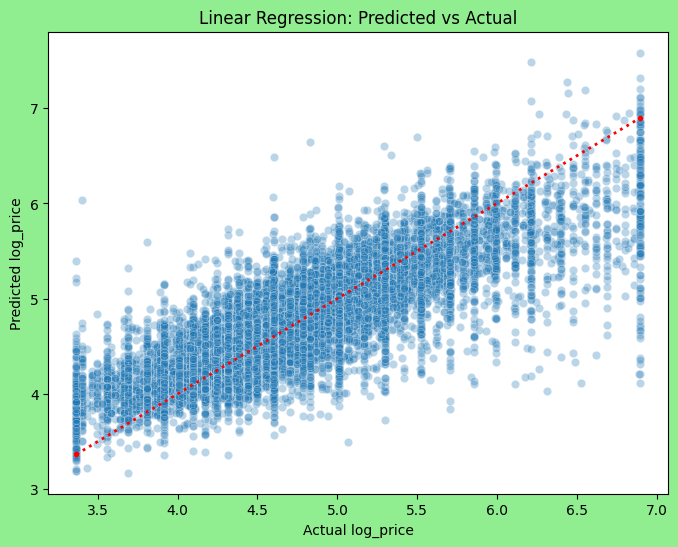

In [61]:
plt.figure(figsize=(8,6), facecolor= 'lightgreen')
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r:.', linewidth=2)
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.title('Linear Regression: Predicted vs Actual')
plt.show()

##**Ridge Regression: -**
####To improve performance, we can use regularized linear models like Ridge or ElasticNet, which handle multicollinearity and can reduce overfitting.


In [62]:
alpha_values = [0.01, 0.1, 0.2, 1, 10, 50, 100]
ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5, n_jobs= -1)
ridge_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.2, 1, 10, 50, 100]},
             scoring='neg_mean_squared_error')

In [63]:
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")

ridge_model = Ridge(alpha = best_alpha_ridge)
ridge_model.fit(X_train_scaled, y_train)


Best alpha for Ridge Regression: 0.01


Ridge(alpha=0.01)

In [64]:
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression -> RMSE: {rmse:.4f}, R2: {r2:.4f}")

Ridge Regression -> RMSE: 0.4033, R2: 0.6704


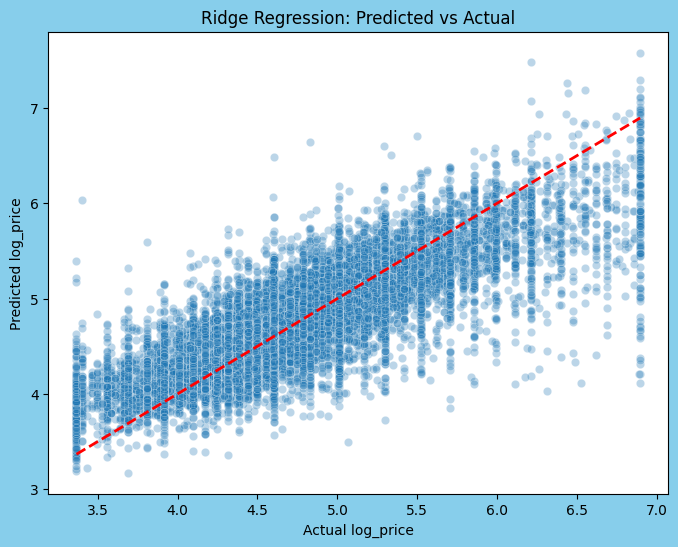

In [66]:
plt.figure(figsize=(8,6), facecolor= 'skyblue')
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.title('Ridge Regression: Predicted vs Actual')
plt.show()


####In our Airbnb price prediction project, we started with Linear Regression and then tried Ridge Regression to reduce overfitting due to high-dimensional features. Ridge performed well, but it retains all features, even those with little predictive power.

####Our dataset has 670 one-hot encoded boolean features, and many of them might be redundant or low-importance.

---

#**ElasticNet**: -

####ElasticNet, which combines L1 (Lasso) and L2 (Ridge) regularization, offers two key advantages:


```
1. Feature Selection:-
  (*). L1 regularization can shrink some co-efficient to zero, automatically removing unimportant features.
2. Regularization & Generalization:-
  (a). L2 regularization keeps coefficients small, reducing overfitting.
  (b). Combining L1 + L2 ensures a sparse yet stable model.

```



In [67]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.7, 0.9]
}

enet = ElasticNet(max_iter = 5000)

enet_cv = GridSearchCV(enet, param_grid= param_grid, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)
enet_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=5000), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.2, 0.5, 0.7, 0.9]},
             scoring='neg_mean_squared_error')

In [68]:
best_params = enet_cv.best_params_
print(f"Best Hyperparameters: {best_params}")

#Train Final ElasticNet model

enet_model = ElasticNet(
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    max_iter=5000
)
enet_model.fit(X_train_scaled, y_train)


Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.2}


ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=5000)

In [69]:
y_pred_enet = enet_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_enet))
r2 = r2_score(y_test, y_pred_enet)

print(f"ElasticNet Regression -> RMSE: {rmse:.4f}, R2: {r2:.4f}")

ElasticNet Regression -> RMSE: 0.4074, R2: 0.6636


####After trying Linear Regression, Ridge, and ElasticNet, we have a good understanding of how linear relationships and regularization affect Airbnb price prediction. ElasticNet helped by removing unimportant features and reducing overfitting, but the model is still limited to linear relationships between features and the target.

##**XGBoost Regressor: -**

####ElasticNet cannot capture these interactions, but XGBoost, a gradient boosting tree-based model, can:

```
1. Handles non-linear relationships naturally

2. Captures interactions between features

3. Works efficiently on wide, sparse datasets (like our 670 boolean features)

4. Often provides better predictive accuracy than linear models
```



In [70]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [71]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regression -> RMSE: {rmse:.4f}, R2: {r2:.4f}")


XGBoost Regression -> RMSE: 0.3727, R2: 0.7185


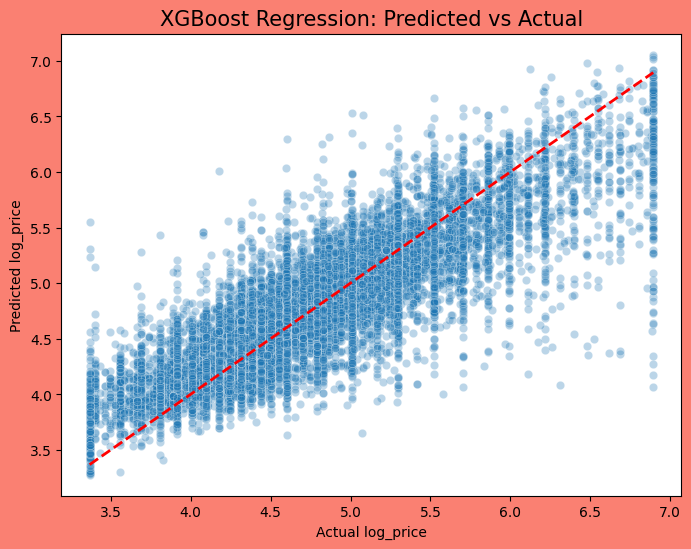

In [72]:
plt.figure(figsize=(8,6), facecolor= 'salmon')
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.title('XGBoost Regression: Predicted vs Actual', fontsize = 15, color = 'k')
plt.show()

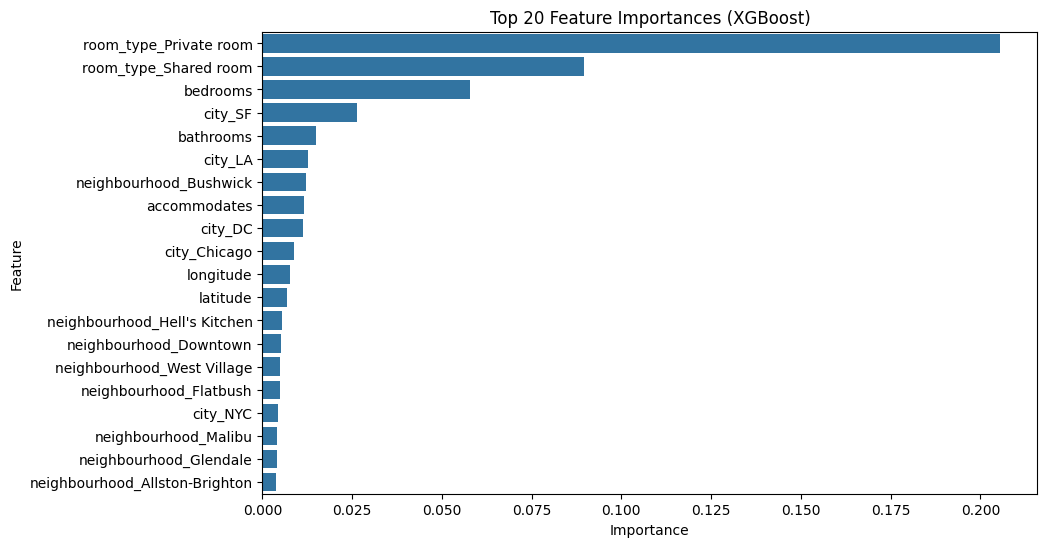

In [73]:
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Top 20 Feature Importances (XGBoost)')
plt.show()


## **Model Mertics:-**
    1. Linear Regression:- RMSE = 0.4033, R2 = 0.67
    2. Ridge Regression :- RMSE = 4033, R2 = 0.67
    3. ElasticNet Regression:- 4074, R2: 0.6636
    4. XGBoost Regression:- RMSE: 0.3727, R2: 0.7185

##**Buisness Conclusion:-**
    1. Key Factors influencing Price:-
        * Room type, property type, number of amenities, and host experience (tenure) strongly affect Airbnb prices.
    2. Insights:-
        * Entire homes/apartments command the higest prices, wihile shared rooms are the cheapest.
        * More amenities and longer-tenured hosts correlate with higher prices.
    3. Best Model:- XGBoost acheived the lowest RMSE(0.37) and highest R2(0.71), making it the most reliable model for price prediction.

##Conclusion: -
    > Linear and regularized linear model provide a strong baseline.
    > XGBoost outperforms them by capturing complex patterns and intersections in Airbnb pricing data.
    